In [1]:
import warnings

warnings.filterwarnings('ignore')

## Constructing Circuits 

In this section we will explore building quantum circuits in pytket with the `Circuit` class and introduce some useful circuit primitives.

### Basic Bell circuit

In pytket we can create an instance of the `Circuit` class and add gates sequentially. We can prepare an entangled Bell state using a Hadamard and a CX gate

$$
\begin{equation}
\text{H} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\,, 
\quad
CX=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}
$$

In [2]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell_circ = Circuit(2, name="Bell")
bell_circ.H(0)
bell_circ.CX(0, 1)
render_circuit_jupyter(bell_circ)

In [3]:
from pytket.extensions.qiskit import AerStateBackend

sv_backend = AerStateBackend()
result_state = sv_backend.run_circuit(bell_circ).get_state()
print("Statevector =", result_state)

Statevector = [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


Compare with the equation below...


$$
\begin{equation}
|\psi \rangle = \frac{1}{\sqrt{2}} \big(|00 \rangle + | 11 \rangle  \big)\,, \qquad \frac{1}{\sqrt{2}} \approx 0.707...
\end{equation}
$$

In [4]:
from pytket.extensions.qiskit import AerBackend

bell_circ.measure_all()
render_circuit_jupyter(bell_circ)

backend = AerBackend()
result = backend.run_circuit(bell_circ, n_shots=1000)
print(result.get_counts())

Counter({(1, 1): 526, (0, 0): 474})


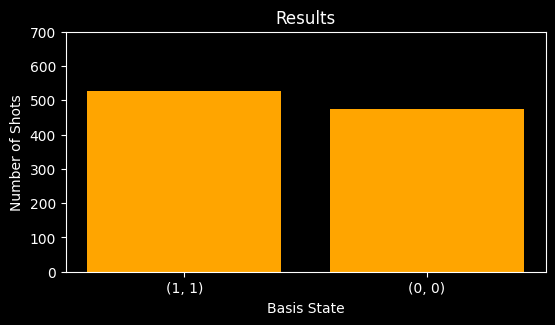

In [5]:
from plotting import plot_results

plot_results(result, dark_mode=True)

## Registers

As an alternative to constrcuting circuits as above, we can create an empty circuit and add registers.

This can be useful for keeping track of what the qubits are used for

In [6]:
from pytket.circuit import OpType

hadamard_circ = Circuit()
m_reg = hadamard_circ.add_q_register("m", 1)
a_reg = hadamard_circ.add_q_register("a", 1)
c_reg = hadamard_circ.add_c_register("c", 1)

hadamard_circ.H(m_reg[0])
hadamard_circ.add_gate(OpType.CU1, [0.61], [m_reg[0], a_reg[0]])
hadamard_circ.H(m_reg[0])
hadamard_circ.Measure(m_reg[0], c_reg[0])

render_circuit_jupyter(hadamard_circ)

### Other Quantum Gates

* Some gates need to be accessed through the `OpType` enum
* Angles are specified as the number of half turns
* See the docs for all OpTypes - https://cqcl.github.io/tket/pytket/api/optype.html

## An Interesting Circuit - The Quantum Fourier Transform

As we've heard the Quantum Fourier Transform (QFT) is an important subroutine in several quantum algorithms including Shor's algorithm for factoring

\begin{equation}
QFT : |j\rangle\ \longmapsto \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle, \quad N= 2^k
\end{equation}

We can build the circuit for the $n$ qubit QFT using $n$ Hadamard gates $\frac{n}{2}$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations. 

$$
\begin{equation}
\text{CU1} = 
\begin{pmatrix}
I & 0 \\
0 & \text{U1}
\end{pmatrix}
\,, \quad 
\text{U1} = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \pi \theta}
\end{pmatrix}
\end{equation}
$$

Note that in the code below we use the `OpType` enum to access the CU1 gate.

We will rotate by smaller and smaller angles of $\theta = \frac{1}{2^{n-1}}$ 

In [7]:
# lets build the QFT for three qubits

qft3_circ = Circuit(3)

qft3_circ.H(0)
qft3_circ.CU1(0.5, 1, 0)
qft3_circ.CU1(0.25, 2, 0)

qft3_circ.H(1)
qft3_circ.CU1(0.5, 2, 1)

qft3_circ.H(2)

qft3_circ.SWAP(0, 2)

[H q[0]; CU1(0.5) q[1], q[0]; CU1(0.25) q[2], q[0]; H q[1]; CU1(0.5) q[2], q[1]; H q[2]; SWAP q[0], q[2]; ]

**Exercise:** Define a `build_qft_circ(n_qubits)` circuit that builds a circuit for the Quantum Fourier Transform for $n$ qubits.

### Circuit Boxes (I)

* Raw quantum gates are sometimes too low level to see whats going on
* We can wrap up sub circuits into boxes and add them to circuits (useful for subroutines).
* Oracle subroutine example below

Define a trivial oracle for Grover's algorithm: 

In [8]:
from pytket import OpType

oracle_circ = Circuit(4, name="Oracle")

oracle_circ.X(0).X(1).X(2).X(3)
oracle_circ.add_gate(OpType.CnZ, [0, 1, 2, 3])
oracle_circ.X(0).X(1).X(2).X(3)

render_circuit_jupyter(oracle_circ)

In [9]:
from pytket.circuit import CircBox

oracle_box = CircBox(oracle_circ)
circ = Circuit(4)
circ.H(0).H(1).H(2).H(3) # Initial superposition
circ.add_circbox(oracle_box, [0, 1, 2, 3])

render_circuit_jupyter(circ)

### Circuit Boxes (II)

* Often we will need synthesise a quantum circuit to implement a gievn unitary
* Unitary synthesis is supported by TKET (Up to 3 qubits)
* **Fact:** A two qubit unitary can be implemented with at most 3 CX gates (KAK decomposition)

Lets see an example with the Fermionic SWAP or $\text{FSWAP}$ gate

$$
\begin{equation}
\text{FSWAP} =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -1 
\end{pmatrix}
\end{equation}
$$

In [10]:
from pytket.circuit import Unitary2qBox
import numpy as np

unitary_2q = np.asarray([
                 [1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, -1]])

u2_box = Unitary2qBox(unitary_2q)

test_circ = Circuit(2)
test_circ.add_unitary2qbox(u2_box, 0, 1)

render_circuit_jupyter(test_circ)

In [11]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(test_circ) # Decompose the box in place

render_circuit_jupyter(test_circ) # view raw circuit 

### Constructing a Circuit from QASM

* OpenQASM (Open Quantum assembly language provides a low level specification of quantum circuits)
* We Can easily build a circuit from a QASM file (And also export a circuit to QASM)

In [12]:
from pytket.qasm import circuit_from_qasm

qpe_circ = circuit_from_qasm("data/qpe.qasm")
print("Total number of gates =", qpe_circ.n_gates)
print("#two qubit gates =", qpe_circ.n_2qb_gates())

render_circuit_jupyter(qpe_circ)

Total number of gates = 21
#two qubit gates = 11


# SWITCH NOTEBOOKS HERE

## Brief section on Optimisation passes

* As we have seen with the phase estimation circuits we can boost the Fidelity of our circuits by reducing the number of gates in our circuit

* Lets try optimising a circuit from quantum chemistry with the general purpose `FullPeepholeOptimise` pass

In [13]:
jw_chem_circ = circuit_from_qasm("data/H2JordanWignerMapper.qasm")
render_circuit_jupyter(jw_chem_circ)

print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

Total gate count = 150
#2 qubit gates = 56


In [14]:
from pytket.passes import FullPeepholeOptimise

FullPeepholeOptimise().apply(jw_chem_circ)

render_circuit_jupyter(jw_chem_circ)
print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

Total gate count = 46
#2 qubit gates = 17


In [15]:
from pytket.passes import auto_rebase_pass

ibm_gateset = {OpType.X, OpType.SX, OpType.Rz, OpType.CX}
ibm_rebase = auto_rebase_pass(ibm_gateset)

ibm_rebase.apply(jw_chem_circ)

True

The `auto_rebase_pass` works well if converting to a well known gateset i.e. one used by a hardware provider like IBM.

Rebases to other univeral sets of 1q and 2q gates can be accomplished with `RebaseCustom`.

In [16]:
render_circuit_jupyter(jw_chem_circ)

We can also compose our own circuit transformations with `SequencePass`.

In [17]:
from pytket.passes import SequencePass

seq_pass = SequencePass([FullPeepholeOptimise(), ibm_rebase])

jw_chem_circ = circuit_from_qasm("data/H2JordanWignerMapper.qasm")

seq_pass.apply(jw_chem_circ)

render_circuit_jupyter(jw_chem_circ)

### Working with Qiskit, Cirq and other libraries

* TKET supports easy conversion to and from qiskit circuits
* Also supported for (Cirq, pennylane, pyquil and Q# through the extensions)
* **Benefit:** Allows TKET compilation features to be used in conjunction with other tools 

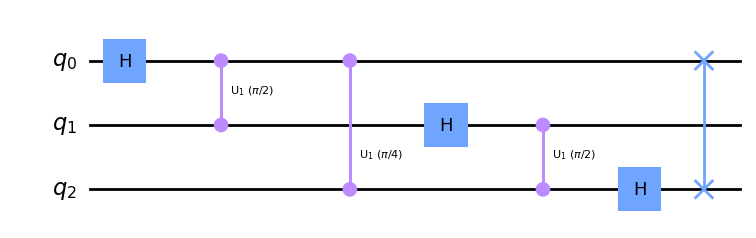

In [18]:
from pytket.extensions.qiskit import tk_to_qiskit #, qiskit_to_tk

qiskit_qc = tk_to_qiskit(qft3_circ) 
# use qiskit_to_tk for conversion to TKET

qiskit_qc.draw('mpl', fold=-1)

## New Features!

## Arbitrary State Prepartation

We can prepare an arbitary quantum state in pytket. Note that the size of the circuit will scale exponentailly with the number of qubits

Lets prepare the following state

$$
\begin{equation}
    |W\rangle = \frac{1}{\sqrt{3}} \big(|001\rangle + |010\rangle +  |100\rangle \big)
\end{equation}
$$

In [19]:
from pytket.circuit import StatePreparationBox

werner_state = 1 / np.sqrt(3) * np.array([0, 1, 1, 0, 1, 0, 0, 0])

werner_state_box = StatePreparationBox(werner_state)

state_circ = Circuit(3)
state_circ.add_gate(werner_state_box, [0, 1, 2])

render_circuit_jupyter(state_circ)

## ToffoliBox

A type of `Circuit` box that can implement an arbitary permutation of computational basis states.

Can "shuffle" the amplitudes of quantum state around as desired

$$
\begin{gather}
    |001\rangle \longmapsto |111\rangle \\
    |111\rangle \longmapsto |001\rangle \\
    |100\rangle \longmapsto |000\rangle \\
    |000\rangle \longmapsto |100\rangle
\end{gather}
$$

In [20]:
from pytket.circuit import ToffoliBox

# Specify the desired permutation of the basis states
mapping = {
    (0, 0, 1): (1, 1, 1),
    (1, 1, 1): (0, 0, 1),
    (1, 0, 0): (0, 0, 0),
    (0, 0, 0): (1, 0, 0),
}

# Define box to perform the permutation
perm_box = ToffoliBox(permutation=mapping)

$$
\begin{equation}
\frac{1}{\sqrt{3}} \big(|001\rangle +  |010\rangle +|100\rangle \big)   \longmapsto \frac{1}{\sqrt{3}} \big(|000\rangle + |010\rangle + |111\rangle \big)
\end{equation}
$$

## ZX Diagrams

We have ZX diagrams in pytket. ZX is a graphical language for reasoning about quantum circuits

ZX has been used extensively in circuit simplification.

Read the [ZX Diagrams](https://cqcl.github.io/pytket/manual/manual_zx.html#) section of the user manual.


![ZX diagram](data/ZX_diagram.png)



## Summary - What have we learned?

* Overview of TKET and the challenges of running quantum algorithms
* Constructing circuits using the primitives available in pytket
* Running basic simulations of quantum circuits
* How to target different quantum devices with pytket
* Optimising circuits 
* Using TKET alongside other quantum SDKs


Install using the command 


<p><center> <code> pip install pytket </code> </center>

Useful links
* [API docs](https://cqcl.github.io/tket/pytket/api/)
* [Notebook examples](https://github.com/CQCL/pytket/tree/main/examples)
* [User Manual](https://cqcl.github.io/pytket/manual/manual_intro.html)

Visit the TKET repository -> https://github.com/CQCL/tket 

Open source  contributions welcome! :) 


## Any Questions?